# **Predicting house prices**

# **1. Dataset description** 

Number of Attributes: 4 textual attributes in addition to the visual attributes that can be extracted from the images.

Attribute Information:
- Number of bedrooms
- Number of bathrooms
- Area (i.e., square footage)
- Zip code

For more info and credits visit:\
https://github.com/omarsayed7/House-price-estimation-from-visual-and-textual-features

<a id="Libraries"></a> <br>
# **2. Libraries and data** 

In [ ]:
import warnings 
from collections import Counter 
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1Ithoy81UTGXRMdAtENRTSrs97QFJmqko/view?usp=sharing' 

id = link.split("/")[-2]
filename= 'HousesInfo.txt'
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(filename)

In [ ]:
header = ['bedrooms', 'bathrooms', 'area', 'zipcode', 'price']
df = pd.read_csv(filename, header=None, delimiter=' ', names=header)

<a id="Known"></a> <br>
# **3. First look at the data** 

In [ ]:
#Searching for null values,data types and shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   535 non-null    int64  
 1   bathrooms  535 non-null    float64
 2   area       535 non-null    int64  
 3   zipcode    535 non-null    int64  
 4   price      535 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 21.0 KB


In [ ]:
#Looking at unique values
df.nunique()

bedrooms       9
bathrooms     14
area         435
zipcode       49
price        369
dtype: int64

In [ ]:
#Looking at a data sample
df.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0000,4053,85255,869500
1,4,3.0000,3343,36372,865200
2,3,4.0000,3923,85266,889000
3,5,5.0000,4022,85262,910000
4,3,4.0000,4116,85266,971226


# **4. Feature Engineering** <a id="Feature Engineering"></a> <br>

## Null treatement

In [ ]:
# Null treatement

## Treatement of Categorical variables

In [ ]:
df['bedrooms'].value_counts()

3     182
4     145
2     123
5      61
6      13
1       5
7       3
8       2
10      1
Name: bedrooms, dtype: int64

In [ ]:
df['bathrooms'].value_counts()

2.0000    217
3.0000     95
2.5000     66
4.0000     43
3.5000     37
1.0000     24
5.0000     16
1.5000     14
4.5000     14
6.0000      3
5.5000      2
6.5000      2
3.2500      1
7.0000      1
Name: bathrooms, dtype: int64

In [ ]:
# round bathrooms to full integer values
#df['bathrooms'] = df['bathrooms'].round(0)

In [ ]:
# Put all zipcodes with less than 4 frequency in Other category
df_zip = df['zipcode'].value_counts().rename_axis('zipcode').reset_index(name='counts')
df_zip['zip_code'] = df_zip['zipcode']
df_zip['zip_code'][df_zip['counts']<4] = 'Other'

# Merge the new zip_code category in the initial dataframe
df = pd.merge(df, df_zip[['zipcode','zip_code']], on=['zipcode'], how='left')
df['zip_code'].value_counts()

92276    100
93510     60
93446     54
92880     49
94501     41
Other     40
91901     32
92677     26
94531     22
85255     12
96019     12
93111     11
92021     11
81524     11
85266     11
95220     10
92802      9
85262      9
62234      7
62214      4
98021      4
Name: zip_code, dtype: int64

In [ ]:
y = df['price']   # Separate target variable
df.drop(['price', 'zipcode'], axis = 1, inplace=True)  # delete unecessary columns

In [ ]:
categ = list(df.select_dtypes(['object']).columns | df.select_dtypes(['category']).columns)
print(categ)

['zip_code']


In [ ]:
# One hot encoder for Categorical Variables
print('Data frame shape before Categorical Values encoding: ',df.shape)
df = pd.get_dummies(data=df, columns=categ)
print('Data frame shape after Categorical Values encoding: ',df.shape)


Data frame shape before Categorical Values encoding:  (535, 4)
Data frame shape after Categorical Values encoding:  (535, 24)


In [ ]:
df.head()

,bedrooms,bathrooms,area,zip_code_62214,zip_code_62234,zip_code_81524,zip_code_85255,zip_code_85262,zip_code_85266,zip_code_91901,zip_code_92021,zip_code_92276,zip_code_92677,zip_code_92802,zip_code_92880,zip_code_93111,zip_code_93446,zip_code_93510,zip_code_94501,zip_code_94531,zip_code_95220,zip_code_96019,zip_code_98021,zip_code_Other
0,4,4.0000,4053,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,3.0000,3343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3,4.0000,3923,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,5.0000,4022,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,4.0000,4116,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Looking at the correlation of the data

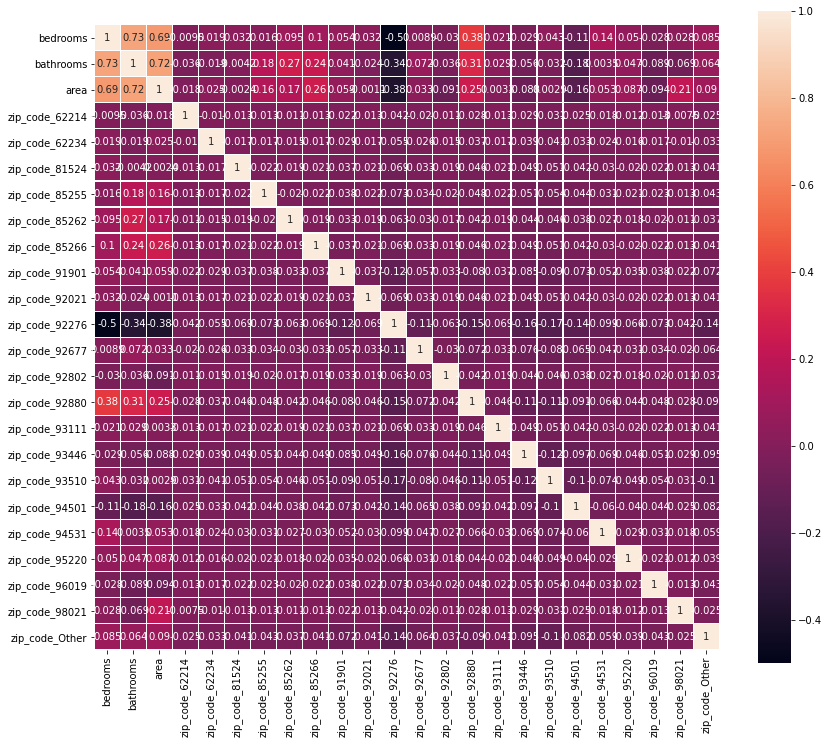

In [ ]:
plt.figure(figsize=(14,12))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(df, 0.9)
print(corr_features)

for column in corr_features:
  df.drop(column, axis=1,inplace=True)

set()


# **5. Train/Test split and Scaling** <a id="Train/Test split and Scaling"></a> <br>


## Import libraries

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

## Prepare and split Dataset into Train and Test

In [ ]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

## Scale input for distance-based models (Linear Regression, Support Vector Regressor)

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

In [ ]:
# normalize target
max_price = y_train.max()
y_train = y_train/ max_price
y_test = y_test / max_price

# **6. Implement models** <a id="Implement models"></a> <br>

### Define model evaluation function


In [ ]:
def model_eval(model,X_test,y_test):
  y_pred = model.predict(X_test)

  y_pred_orig = y_pred * max_price
  y_test_orig = y_test * max_price

  print("Test mean           : {:.2f}".format(np.mean(y_test_orig)))
  print("Price Std (baseline): {:.2f}".format(np.std(y_test_orig)))
  print("Test RMSE           : {:.2f}".format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))))
  print("Test MAE            : {:.2f}".format(mean_absolute_error(y_test_orig,y_pred_orig)))
  print("R² score            : {:.4f}".format(r2_score(y_test_orig,y_pred_orig)))

### Linear Regression

In [ ]:
# import libraries
from sklearn.linear_model import LinearRegression

### Support Vector Reggresor

In [ ]:
# import libraries
from sklearn.svm import SVR

### Decision Tree Regressor

In [ ]:
# import libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

### Ensemble methods: Random Forrest Regressor

In [ ]:
# import libraries
from sklearn.ensemble import RandomForestRegressor

### Ensemble methods: XGBoost Regressor

In [ ]:
# import libraries
from xgboost import XGBRegressor